In [47]:

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [49]:
df = pd.read_csv("data/statcast_pitch_swing_data_20240402_20240630.csv")
df = df.dropna(subset=['bat_speed', 'swing_length'])
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
3628,FS,2024-04-03,90.1,-2.36,5.30,"Ramírez, Harold",623912,543135,strikeout,swinging_strike,...,0,0,1,Standard,Standard,244.0,-0.023,-0.084,77.264946,7.79280
3631,FF,2024-04-03,96.7,-2.49,5.03,"Ramírez, Harold",623912,543135,NaN,foul,...,0,0,1,Standard,Standard,236.0,0.000,0.000,68.912017,6.29951
3633,CU,2024-04-03,83.6,-0.87,6.10,"Fermin, Freddy",666023,669203,strikeout,swinging_strike,...,0,2,0,Standard,Standard,56.0,0.012,-0.143,43.064275,7.35609
3637,FC,2024-04-03,95.9,-1.12,5.91,"Fermin, Freddy",666023,669203,NaN,foul,...,0,2,0,Standard,Standard,183.0,0.000,0.000,69.626229,7.35832
3638,FS,2024-04-03,88.2,-2.42,5.41,"Ramírez, Harold",623912,543135,NaN,foul_tip,...,0,0,1,Standard,Standard,245.0,0.000,-0.023,79.459217,7.96483


In [15]:
df.shape

(155812, 94)

In [51]:
df_test = df.copy()

In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155812 entries, 3628 to 346249
Data columns (total 94 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   pitch_type                       155811 non-null  object 
 1   game_date                        155812 non-null  object 
 2   release_speed                    155808 non-null  float64
 3   release_pos_x                    155810 non-null  float64
 4   release_pos_z                    155810 non-null  float64
 5   player_name                      155812 non-null  object 
 6   batter                           155812 non-null  int64  
 7   pitcher                          155812 non-null  int64  
 8   events                           70858 non-null   object 
 9   description                      155812 non-null  object 
 10  spin_dir                         0 non-null       float64
 11  spin_rate_deprecated             0 non-null       float64
 12  brea

In [55]:
df_test['on_3b'] = df_test['on_3b'].notna().astype(int)
df_test['on_2b'] = df_test['on_2b'].notna().astype(int)
df_test['on_1b'] = df_test['on_1b'].notna().astype(int)

In [41]:
player_avg_data = df.groupby('player_name').agg(
    avg_swing_length=('swing_length', 'mean'),
    avg_bat_speed=('bat_speed', 'mean'),
    woba_value=('woba_value', 'mean'),
    min_bat_speed=('bat_speed', 'min'),
    max_bat_speed=('bat_speed', 'max'),
    min_swing_length=('swing_length', 'min'),
    max_swing_length=('swing_length', 'max'),
    std_swing_length=('swing_length', 'std'),
    std_bat_speed=('bat_speed', 'std')
).reset_index()

In [57]:
df_with_averages = df_test.merge(player_avg_data, on='player_name', how='left')
df_with_averages.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,swing_length,avg_swing_length,avg_bat_speed,woba_value_y,min_bat_speed,max_bat_speed,min_swing_length,max_swing_length,std_swing_length,std_bat_speed
0,FS,2024-04-03,90.1,-2.36,5.30,"Ramírez, Harold",623912,543135,strikeout,swinging_strike,...,7.79280,7.223357,69.909003,0.285621,34.753747,84.983240,4.11711,9.28871,0.957294,7.547001
1,FF,2024-04-03,96.7,-2.49,5.03,"Ramírez, Harold",623912,543135,NaN,foul,...,6.29951,7.223357,69.909003,0.285621,34.753747,84.983240,4.11711,9.28871,0.957294,7.547001
2,CU,2024-04-03,83.6,-0.87,6.10,"Fermin, Freddy",666023,669203,strikeout,swinging_strike,...,7.35609,7.327361,67.669297,0.322400,6.169305,81.909608,1.70352,9.22151,0.967855,9.482418
3,FC,2024-04-03,95.9,-1.12,5.91,"Fermin, Freddy",666023,669203,NaN,foul,...,7.35832,7.327361,67.669297,0.322400,6.169305,81.909608,1.70352,9.22151,0.967855,9.482418
4,FS,2024-04-03,88.2,-2.42,5.41,"Ramírez, Harold",623912,543135,NaN,foul_tip,...,7.96483,7.223357,69.909003,0.285621,34.753747,84.983240,4.11711,9.28871,0.957294,7.547001


In [103]:
# Calculate the difference to determine if above or below the player average
df_with_averages['bat_speed_zscore'] = (df_with_averages['bat_speed'] - df_with_averages['avg_bat_speed']) / df_with_averages['std_bat_speed']
df_with_averages['swing_length_zscore'] = (df_with_averages['swing_length'] - df_with_averages['avg_swing_length']) / df_with_averages['std_swing_length'] 
df_with_averages.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,min_bat_speed,max_bat_speed,min_swing_length,max_swing_length,std_swing_length,std_bat_speed,bat_speed_diff,swing_length_diff,bat_speed_zscore,swing_length_zscore
0,FS,2024-04-03,90.1,-2.36,5.30,"Ramírez, Harold",623912,543135,strikeout,swinging_strike,...,34.753747,84.983240,4.11711,9.28871,0.957294,7.547001,0.974684,0.594846,0.974684,0.594846
1,FF,2024-04-03,96.7,-2.49,5.03,"Ramírez, Harold",623912,543135,NaN,foul,...,34.753747,84.983240,4.11711,9.28871,0.957294,7.547001,-0.132104,-0.965061,-0.132104,-0.965061
2,CU,2024-04-03,83.6,-0.87,6.10,"Fermin, Freddy",666023,669203,strikeout,swinging_strike,...,6.169305,81.909608,1.70352,9.22151,0.967855,9.482418,-2.594805,0.029683,-2.594805,0.029683
3,FC,2024-04-03,95.9,-1.12,5.91,"Fermin, Freddy",666023,669203,NaN,foul,...,6.169305,81.909608,1.70352,9.22151,0.967855,9.482418,0.206375,0.031987,0.206375,0.031987
4,FS,2024-04-03,88.2,-2.42,5.41,"Ramírez, Harold",623912,543135,NaN,foul_tip,...,34.753747,84.983240,4.11711,9.28871,0.957294,7.547001,1.265432,0.774551,1.265432,0.774551


In [109]:
df_count = df_with_averages[['balls', 'strikes', 'bat_speed_zscore']]

df1 = df_count.groupby(['balls', 'strikes']).agg(
    avgz = ('bat_speed_zscore', 'mean')
).reset_index()

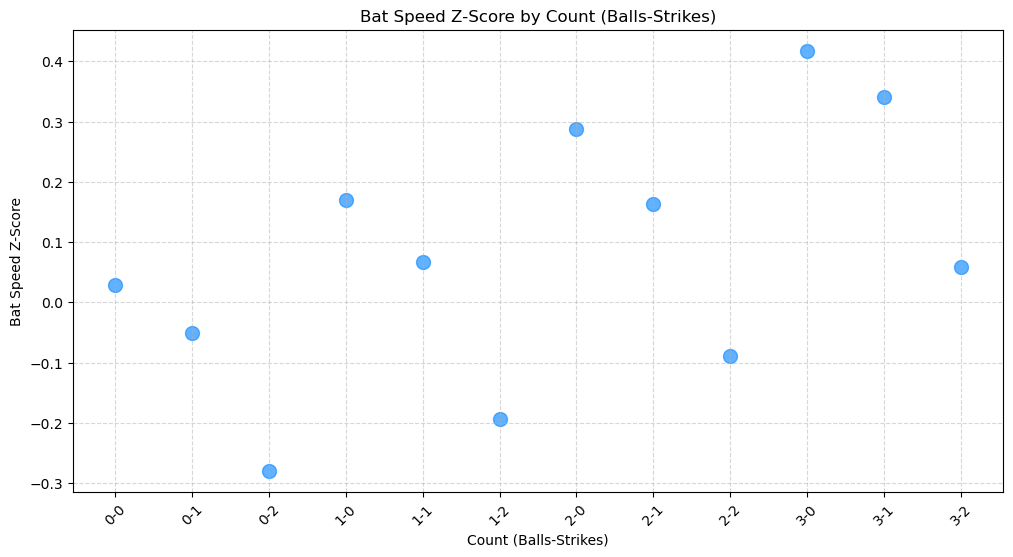

In [115]:
# Create the 'count' column
df1['count'] = df1['balls'].astype(str) + '-' + df1['strikes'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df1['count'], df1['avgz'], color='dodgerblue', s=100, alpha=0.7)
plt.xlabel('Count (Balls-Strikes)')
plt.ylabel('Bat Speed Z-Score')
plt.title('Bat Speed Z-Score by Count (Balls-Strikes)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [117]:
df_count = df_with_averages[['balls', 'strikes', 'swing_length_zscore']]

df1 = df_count.groupby(['balls', 'strikes']).agg(
    avgz = ('swing_length_zscore', 'mean')
).reset_index()

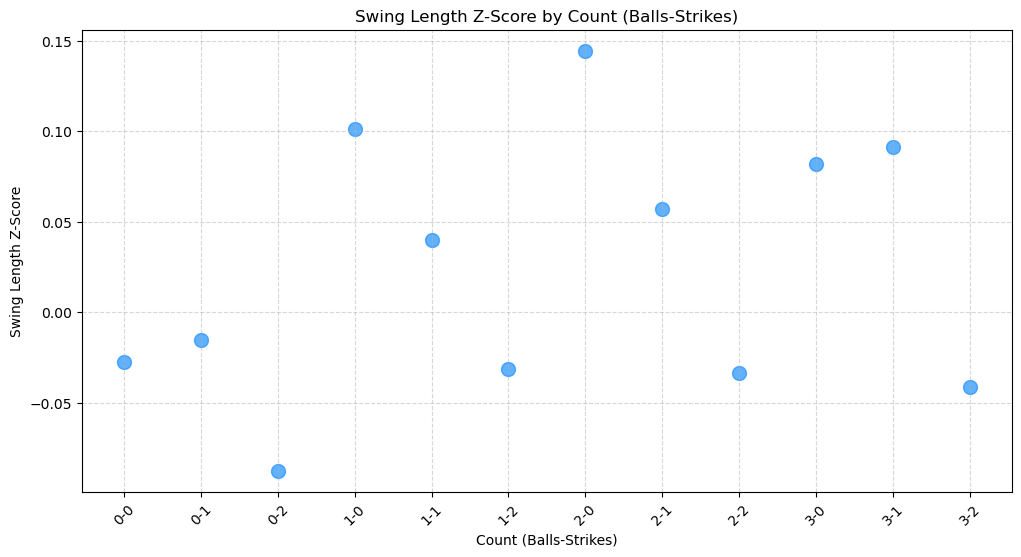

In [121]:
# Create the 'count' column
df1['count'] = df1['balls'].astype(str) + '-' + df1['strikes'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df1['count'], df1['avgz'], color='dodgerblue', s=100, alpha=0.7)
plt.xlabel('Count (Balls-Strikes)')
plt.ylabel('Swing Length Z-Score')
plt.title('Swing Length Z-Score by Count (Balls-Strikes)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()